# Continuous Control of double-jointed arms with DDPG agent

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

The environment to solve consists of a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

Two separate versions of the Unity environment are provided:

The first version contains a single agent.
The second version contains 20 identical agents, each with its own copy of the environment.

The second version will be solved with a DDPG agent for this project. The [DDPG agent provided by Udacity](https://github.com/udacity/deep-reinforcement-learning/) is adopted with a slight modification to take into account the number of agents.

### Model and Architecture

DDPG is a model-free policy-based reinforcement learning algorithm where agent learns by observing state spaces with no prior knowledge of environemnt dynamic. Learning improves by using policy gradient optimization algorithm.

DDPG is one of the known Actor-Critic models. Actor is policy-based where learning is expected to be inefficient (taking a while to converge) with high variance. Whereas Critic is value-based and is expected to be high bias. The collaboration of Actor and Critic compliment each other while overcoming their shortcomings. 

The Actor model is a neural network with 3 fully connected layers with features 33 > 400 > 300 > 4  
Tanh is used in the final layer that maps states to actions. Batch normalization is used for mini batch training.

The Critic model is similar to Actor model except the final layer maps states and actions to Q-values.

#### The hyperparameters of the model are set as: 

1. Replay buffer size: BUFFER_SIZE = int(1e6)    
2. Minibatch size: BATCH_SIZE = 128 
3. Discount factor: GAMMA = 0.99
6. Soft update of target parameters: TAU = 1e-3  
4. Learning rate of the actor: LR_ACTOR = 1e-4         
5. Learning rate of the critic: LR_CRITIC = 3e-4   
7. L2 weight decay: WEIGHT_DECAY = 0.0001       

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [95]:
from unityagents import UnityEnvironment
import numpy as np

import datetime
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ddpg_agent import Agents

In [64]:
# Confirm Torch version
print(torch.__version__)

0.4.1


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# Modify path based on your machine config. 
# Single agent
#env = UnityEnvironment(file_name='./Reacher/Reacher.exe')
# 20 agents
env = UnityEnvironment(file_name='./Reacher_M/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
print("Using {}".format(brain_name))

Using ReacherBrain


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [7]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Available device = {}'.format(device))

Available device = cuda:0


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [21]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14999999664723873


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [96]:
agents = Agents(state_size=state_size, 
                action_size=action_size, 
                num_agents=num_agents, 
                random_seed=0)
print(agents.actor_local)
print(agents.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


In [93]:
def ddpg(n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                print('\tSteps: ', t)
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.\
              format(i_episode, np.mean(scores_deque), np.mean(score)), end="")
        avg_score = np.mean(scores_deque)
        if i_episode % 20 == 0 or avg_score > 30:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth') 
            if avg_score > 30:
                print('\nEnvironment solved in {:d} episodes!'.format(i_episode))
                break
    return scores

In [97]:
scores = ddpg()

Episode 20	Average Score: 3.35	Score: 9.289
Episode 40	Average Score: 12.94	Score: 28.749
Episode 60	Average Score: 19.70	Score: 35.957
Episode 80	Average Score: 23.99	Score: 37.469
Episode 100	Average Score: 26.63	Score: 36.810
Episode 110	Average Score: 30.20	Score: 37.576

Environment solved in 110 episodes!


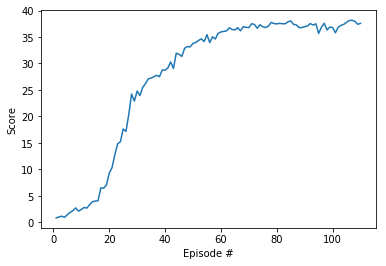

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [84]:
scores = ddpg()

Episode 20	Average Score: 15.20	Score: 37.195
Episode 40	Average Score: 26.79	Score: 38.614
Episode 56	Average Score: 30.01	Score: 37.419

Environment solved in 56 episodes!


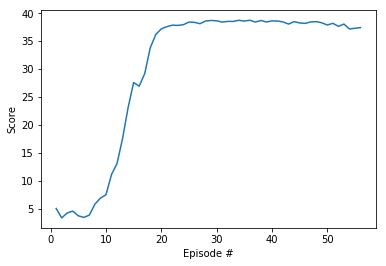

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [4]:
env.close()

### Improvement suggestion

Priority Experienced Replay as introduced in the paper [A novel DDPG method with prioritized experience replay](https://www.researchgate.net/publication/321406256_A_novel_DDPG_method_with_prioritized_experience_replay)  can be used to improve the DDPG agent. The method emphasizes and samples more on important experience. As such efficiency in training time and stability of training process are anticipated. 